In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import random
import shutil

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, MaxPooling2D, Flatten, Dropout, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

import glob
import PIL.Image as pilimg
import warnings
warnings.filterwarnings(action='ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Fetching Our Data
We are using the Dataset provided by [prajnasb](https://github.com/prajnasb/observations)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
DATAPATH = '/content/drive/My Drive/Mask_Detector/dataset/'
MASKPATH = '/content/drive/My Drive/Mask_Detector/dataset/with_mask/'
NOMASKPATH = '/content/drive/My Drive/Mask_Detector/dataset/without_mask/'
TESTPATH = '/content/drive/My Drive/Mask_Detector/testdataset'

# Visualizing our data

In [4]:
def view(pth):
    images = list()
    for img in random.sample(os.listdir(pth),9):
        images.append(img)
    i = 0
    fig,ax = plt.subplots(nrows=3, ncols=3, figsize=(30,20))
    for row in range(3):
        for col in range(3):
            ax[row,col].imshow(cv2.imread(os.path.join(pth,images[i])))
            i+=1

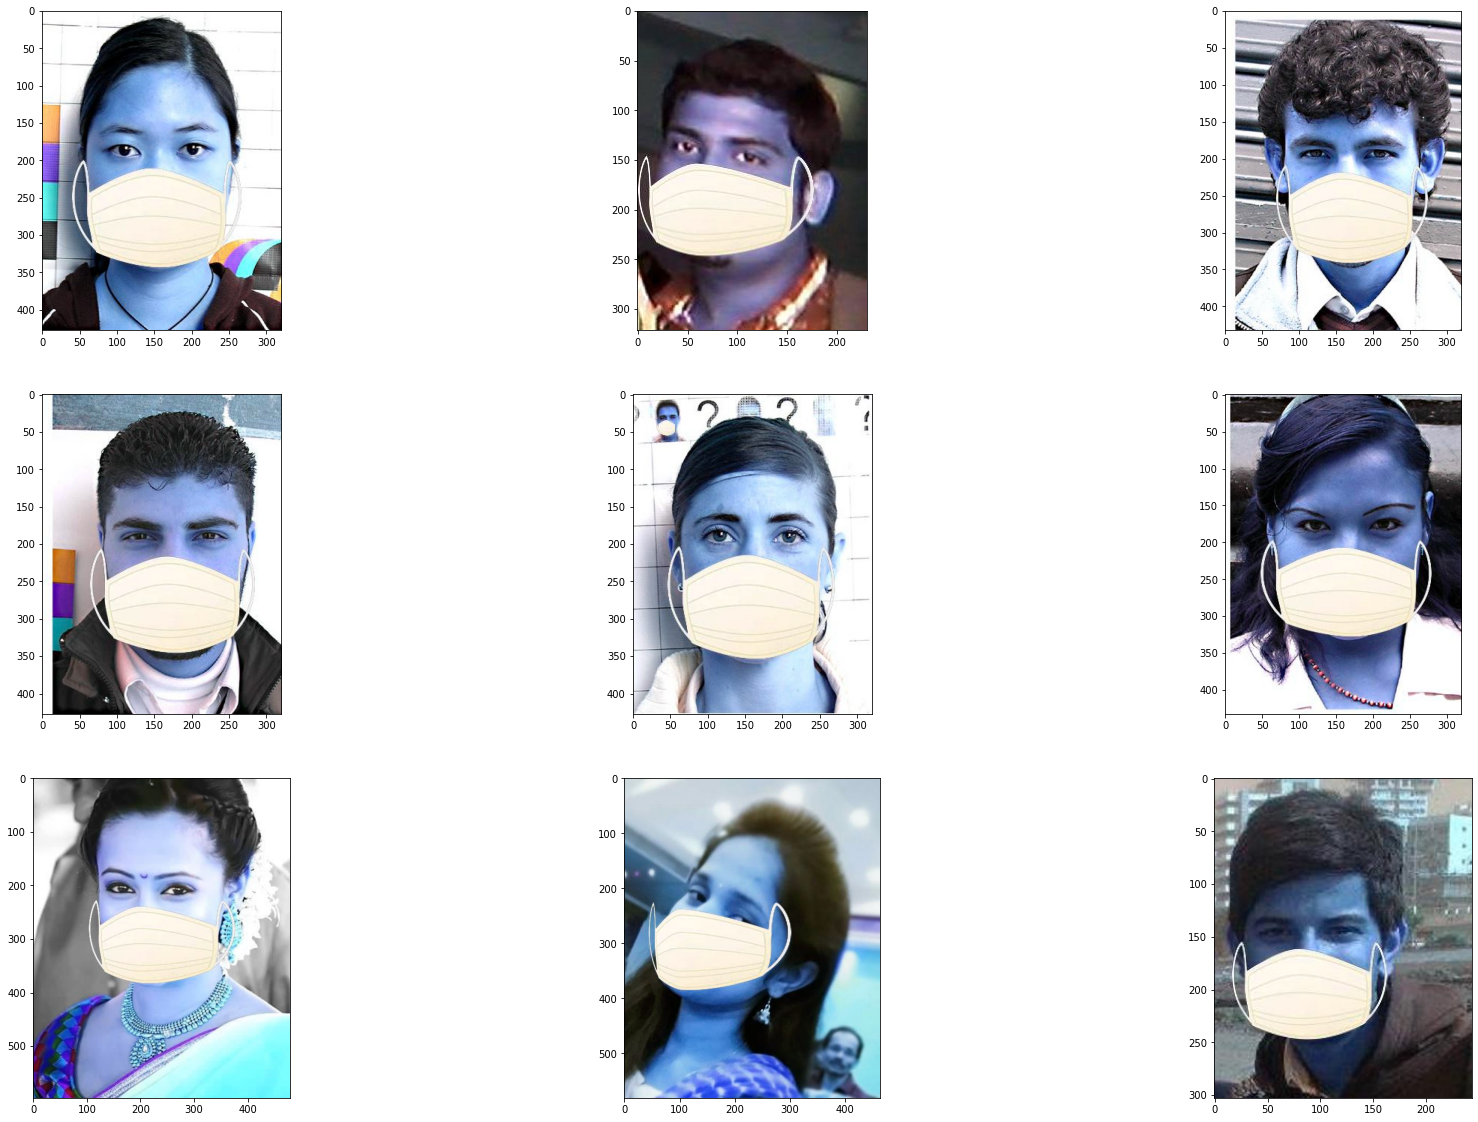

In [5]:
view(MASKPATH)

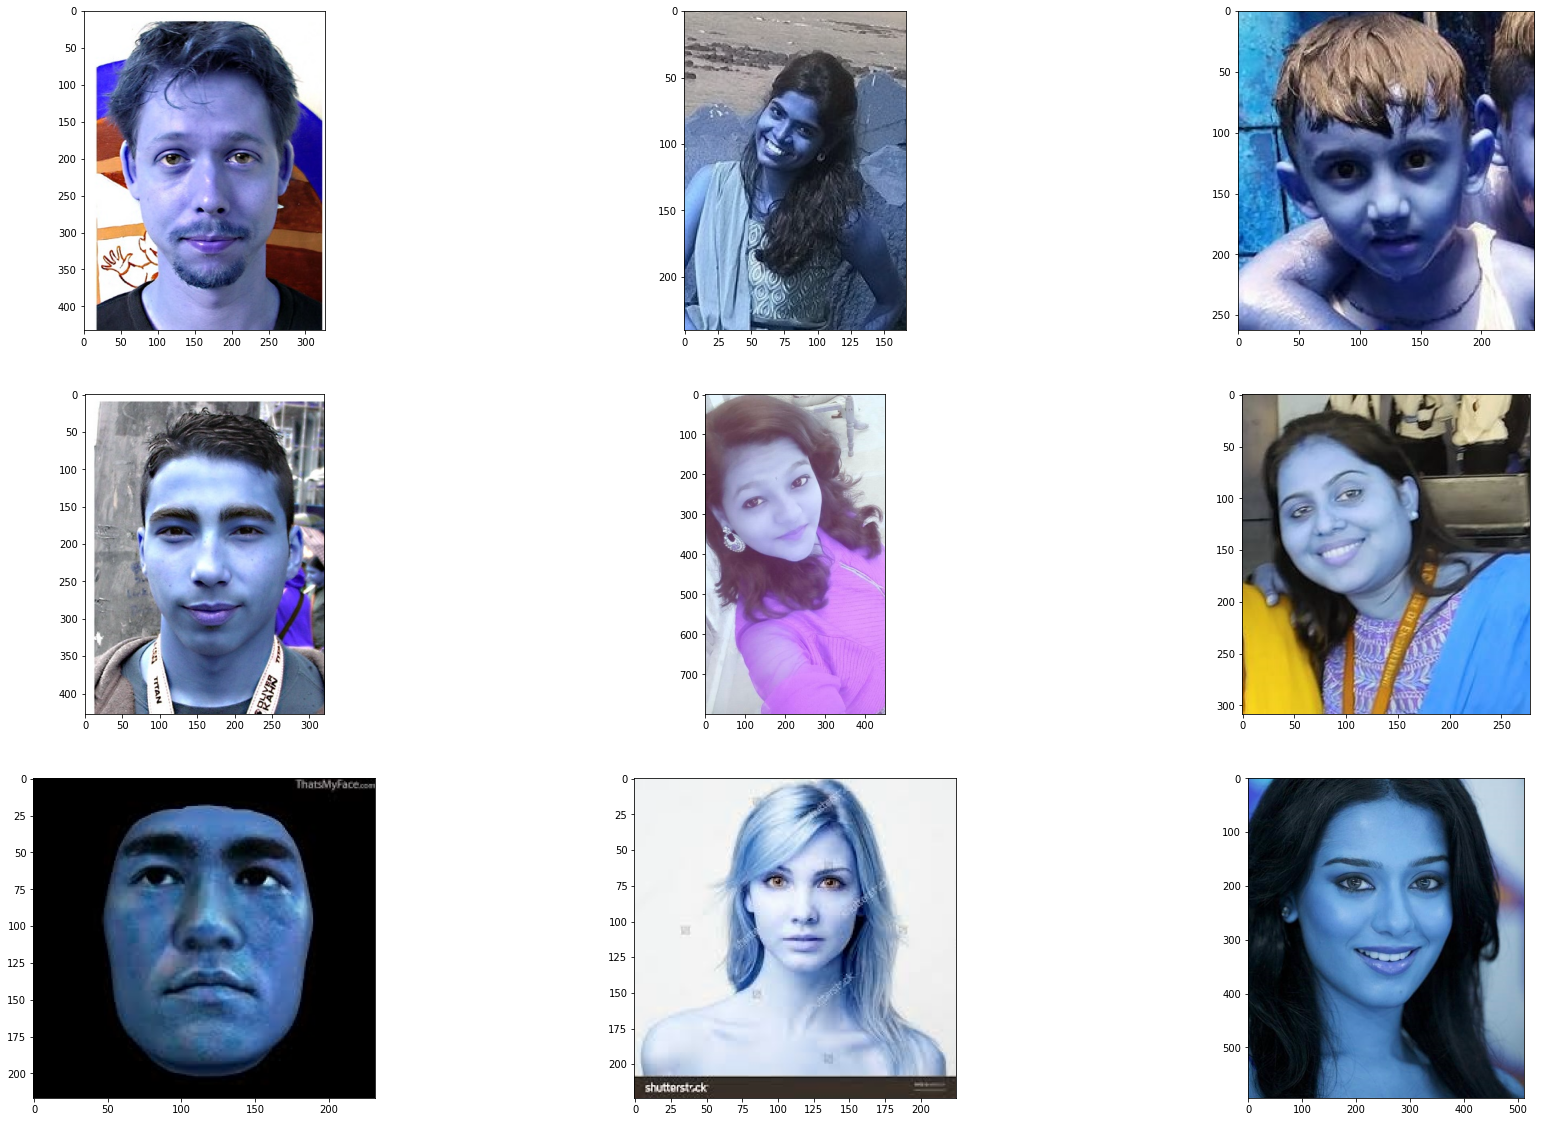

In [6]:
view(NOMASKPATH)

# Analysing our Data

In [7]:
fig = go.Figure(
    data=[go.Pie(labels=['WITHMASK','WITHOUTMASK'], 
        values=[len(os.listdir(MASKPATH)),len(os.listdir(NOMASKPATH))])
    ])
fig.show()

So clearly our Data is not highly imbalanced. So we have good data to work around with

# Splitting Training Test
We have <br>
NO MASK : 667 <br>
WITH MASK : 690 <br>
So now we split data into train test sets. We'll take around 2% data for testing purposes.


In [8]:
if not os.path.exists(TESTPATH):
  os.mkdir(TESTPATH)
  os.mkdir(os.path.join(TESTPATH,'with_mask'))
  os.mkdir(os.path.join(TESTPATH,'without_mask'))

In [9]:
def getTest(pth):
    dataSplit = int(np.ceil(len(os.listdir(pth))*0.02))
    for img in os.listdir(pth)[-dataSplit:]:
        shutil.move(os.path.join(pth,img), os.path.join('testdata'.join(pth.split('data')),img))
getTest(MASKPATH)
getTest(NOMASKPATH)

In [10]:
len(os.listdir(MASKPATH)),len(os.listdir(NOMASKPATH))

(358, 355)

In [11]:
len(os.listdir(os.path.join(TESTPATH,'with_mask'))),len(os.listdir(os.path.join(TESTPATH,'without_mask')))

(8, 8)

# Preparing Data Input Pipelines

In [12]:
BATCH_SIZE = 32

In [13]:
trainGen = ImageDataGenerator(
    rescale= 1/255.,
    horizontal_flip=True,
    validation_split = 0.1
)

testGen = ImageDataGenerator(
    rescale= 1/255.,
)

In [14]:
train = trainGen.flow_from_directory(
    DATAPATH, 
    target_size=(224, 224),
    classes=['with_mask','without_mask'],
    class_mode='categorical', 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    subset='training'
)

validation = trainGen.flow_from_directory(
    DATAPATH, 
    target_size=(224, 224),
    classes=['with_mask','without_mask'],
    class_mode='categorical', 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    subset='validation'
)

test = testGen.flow_from_directory(
    TESTPATH, 
    target_size=(224, 224), 
    classes=['with_mask','without_mask'],
    class_mode='categorical', 
    batch_size=BATCH_SIZE, 
    shuffle=True,
)

Found 643 images belonging to 2 classes.
Found 70 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


# Model Building

In [16]:
mob = MobileNetV2(
    # input_shape = (224,224,3),
    include_top = False,
    weights = 'imagenet',
)
mob.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [17]:
model = Sequential()
model.add(mob)
model.add(GlobalAveragePooling2D())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, None, None, 1280)  2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                81984     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 2,340,098
Trainable params: 82,114
Non-trainable params: 2,257,984
_________________________________________________________________


In [18]:
model.compile(optimizer=Adam(),loss='categorical_crossentropy',metrics=['acc'])

In [19]:
checkpoint = ModelCheckpoint(
    '/content/drive/My Drive/mask_detect.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='min'
)

In [20]:
hist = model.fit(
    train,
    epochs = 15,
    validation_data = validation,
    callbacks = [checkpoint]
)

Epoch 1/15
21/21 [==============================] - ETA: 0s - loss: 0.2105 - acc: 0.9114
Epoch 00001: val_loss improved from inf to 0.01120, saving model to /content/drive/My Drive/mask_detect.h5
21/21 [==============================] - 191s 9s/step - loss: 0.2105 - acc: 0.9114 - val_loss: 0.0112 - val_acc: 1.0000
Epoch 2/15
21/21 [==============================] - ETA: 0s - loss: 0.0220 - acc: 0.9922
Epoch 00002: val_loss improved from 0.01120 to 0.00703, saving model to /content/drive/My Drive/mask_detect.h5
21/21 [==============================] - 3s 161ms/step - loss: 0.0220 - acc: 0.9922 - val_loss: 0.0070 - val_acc: 1.0000
Epoch 3/15
21/21 [==============================] - ETA: 0s - loss: 0.0096 - acc: 0.9984
Epoch 00003: val_loss improved from 0.00703 to 0.00689, saving model to /content/drive/My Drive/mask_detect.h5
21/21 [==============================] - 3s 159ms/step - loss: 0.0096 - acc: 0.9984 - val_loss: 0.0069 - val_acc: 1.0000
Epoch 4/15
21/21 [========================

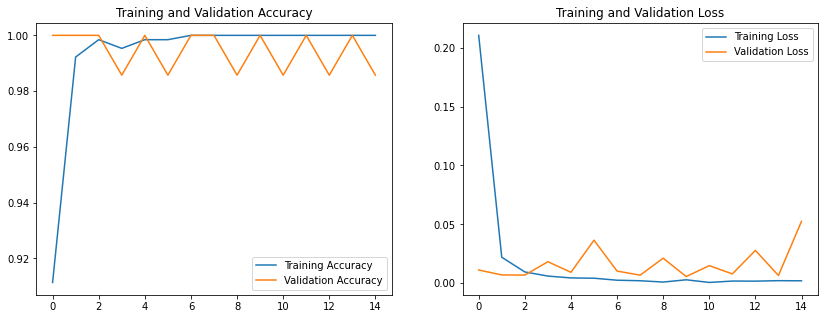

In [22]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(hist.history['acc'], label='Training Accuracy')
plt.plot(hist.history['val_acc'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [23]:
model.evaluate(test)

1/1 [==============================] - 0s 2ms/step - loss: 0.4479 - acc: 0.9375


[0.44785094261169434, 0.9375]